In [9]:
import imutils
from imutils.video import VideoStream, FileVideoStream
from imutils import face_utils
import cv2
import time
import numpy as np
import dlib
from collections import OrderedDict
from pose_estimator import PoseEstimator
from stabilizer import Stabilizer
import matplotlib.pyplot as plt

# Helper functions

# Face streamer

In [2]:
# Face streamer class 
class face_streamer:
    def __init__(self, predictor_path, filename = None):
        self.filename = filename
        
        # Initialize dlib's face detector (HOG-based)
        self.detector = dlib.get_frontal_face_detector()
        
        # Create landmark predictor.
        self.predictor = dlib.shape_predictor("../detect-face-parts/shape_predictor_68_face_landmarks.dat")
        
        # Facial landmarks that we use
        self.facial_landmarks_idxs = OrderedDict([
            ("nose", (27, 36)),
            ("face", (0, 26))
        ])
        
        # Define the pose estimator and stabilizer 
        self.height, self.width = 300, 400
        self.pose_estimator = PoseEstimator(img_size=(self.height, self.width))
        # Define scalar stabilizers for pose.
        self.pose_stabilizers = [Stabilizer(state_num=2, measure_num=1, cov_process=0.1, cov_measure=0.1) 
                            for _ in range(6)]
        
        # RGB and RPY to track
        self.red = []
        self.green = []
        self.blue = []
        self.roll = []
        self.pitch = []
        self.yaw = []
        
        
    def start_stream(self):
        if self.filename:
            self.vs = FileVideoStream(self.filename).start()
        else:
            self.vs = VideoStream(src=0).start()
        print("[INFO] camera sensor warming up...")
        time.sleep(2.0)
            
    def end_stream(self):
        # Do some cleanup
        cv2.destroyAllWindows()
        self.vs.stop()
    
    def stream(self, display_face_bb = False, display_landmarks = False, display_overlay = False):
        self.start_stream()
        # Loop and stream
        while True:
            # Read and resize the frame
            frame = self.vs.read()
            frame = imutils.resize(frame, width=400)
            # Get grayscale image and extract the bounding boxes with the detector 
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            rects = self.detector(gray, 0)
            # Loop over the face detections 
            for rect in rects:
                # Get the bounding box 
                (bX, bY, bW, bH) = face_utils.rect_to_bb(rect)
                # TODO -- take only the ROI, not the whole box 
                # Get RGB values
                self.update_rgb(frame[bY:bH+bY, bX:bW+bX,:]) 
                # Determine the facial landmarks for the face region, then
                # convert the facial landmark (x, y)-coordinates to a NumPy
                # array.
                shape = face_utils.shape_to_np(self.predictor(gray, rect))
                # Try pose estimation
                pose = self.pose_estimator.solve_pose_by_68_points(shape.astype('float'))
                # Stabilize the pose
                steady_pose = self.stablize_pose(pose)
                # Display bounding box if true
                if display_face_bb:
                    frame = self.display_face_bb(frame, (bX, bY, bW, bH))
                # Display facial landmarks if true
                if display_landmarks:
                    frame = self.display_landmarks(frame, shape)
                # Display the landmark overlay if true
                if display_overlay:
                    frame = self.display_overlay(frame, shape)                
                
            # Show the frame
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            
            # If the `q` key was pressed, break from the loop.
            if key == ord("q"):
                # Do some cleanup 
                self.end_stream()
                del self.vs
                break
                
    # TODO -- only use the mask values, not just the box 
    def update_rgb(self, mask):
        self.red.append(np.average(mask[:,:,0]) / 255)
        self.green.append(np.average(mask[:,:,1]) / 255)
        self.blue.append(np.average(mask[:,:,2]) / 255)
                
    def stablize_pose(self, pose):
        steady_pose = []
        pose_np = np.array(pose).flatten()
        for value, ps_stb in zip(pose_np, self.pose_stabilizers):
            ps_stb.update([value])
            steady_pose.append(ps_stb.state[0])
        steady_pose = np.reshape(steady_pose, (-1, 3))
        return steady_pose 
    
    def display_face_bb(self, frame, bounds):
        (bX, bY, bW, bH) = bounds
        # Draw the bounding box on the frame
        cv2.rectangle(frame, (bX, bY), (bW+bX, bH+bY), (0, 255, 0), 1)
        return frame
    
    def display_landmarks(self, frame, shape):
        for (name, (i, j)) in self.facial_landmarks_idxs.items():
            # Loop over the subset of facial landmarks, drawing the specific face part
            for (x, y) in shape[i:j]:
                cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
        return frame
    
    # Displays the overlay of the landmarks 
    def display_overlay(self, frame, shape, colors=None, alpha=0.75):
        # Create two copies of the input image -- one for the
        # overlay and one for the final output image
        overlay = frame.copy()
        output = frame.copy()

        # If the colors list is None, initialize it with a unique
        # color for each facial landmark region
        if colors is None:
            colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
                (168, 100, 168), (158, 163, 32),
                (163, 38, 32), (180, 42, 220), (100, 150, 250)]

        # Loop over the facial landmark regions individually
        for (i, name) in enumerate(self.facial_landmarks_idxs.keys()):
            # Grab the (x, y)-coordinates associated with the
            # face landmark
            (j, k) = self.facial_landmarks_idxs[name]
            pts = shape[j:k]
            if name == 'face':
                hull = cv2.convexHull(pts)
                cv2.drawContours(overlay, [hull], -1, colors[i], -1)

        # Apply the transparent overlay
        cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

        # Return the output image
        return output
    
    def plot_rgb(self):
        num_frames = range(len(self.red))
        plt.plot(num_frames, self.red, color='red', label = 'red')
        plt.plot(num_frames, self.green, color='green', label='green')
        plt.plot(num_frames, self.blue, color='blue', label='blue')

    def draw_aam(self):
        return
                
# next

In [3]:
FACIAL_LANDMARKS_IDXS = OrderedDict([
    ("nose", (27, 36)),
    ("face", (0, 26))
])
predictor_path = "../detect-face-parts/shape_predictor_68_face_landmarks.dat"
fs = face_streamer(predictor_path)
fs.stream(display_face_bb = True, display_landmarks = False, display_overlay = False)
# del fs

successful init
[INFO] camera sensor warming up...


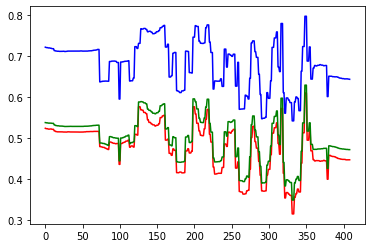

In [10]:
# Graph RGB
fs.plot_rgb()

In [5]:
def stream_face_detection(filename=None):
    # To capture video from webcam.
    if not _filename:
        vs = VideoStream(src=0).start()
    else:
        # To use a video file as input 
        vs = FileVideoStream(filename).start()
    time.sleep(2.0)

    while True:
        # grab frame and resize
        frame = vs.read()
        frame = imutils.resize(frame, width=400)
        # grab the frame dimensions and convert it to a blob
        (h, w) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,
            (300, 300), (104.0, 177.0, 123.0))
        # pass the blob through the network and obtain the detections and
        # predictions
        net.setInput(blob)
        detections = net.forward()
        for i in range(0, detections.shape[2]):
            # extract the confidence (i.e., probability) associated with the
            # prediction
            confidence = detections[0, 0, i, 2]
            # filter out weak detections by ensuring the `confidence` is
            # greater than the minimum confidence
            if confidence < confidence_threshold:
                continue
            # compute the (x, y)-coordinates of the bounding box for the
            # object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # draw the bounding box of the face along with the associated
            # probability
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY),
                (0, 0, 255), 2)
            cv2.putText(frame, text, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

        # show the output frame
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            # do a bit of cleanup
            cv2.destroyAllWindows()
            vs.stop()
            break

In [6]:
def show_image(_path):
    img = cv2.imread(_path,1)
    while True:
        cv2.imshow('image',img)
        key = cv2.waitKey(1) & 0xFF
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            # do a bit of cleanup
            cv2.destroyAllWindows()
            break